# User Interaction with our Model
This Notebook a simple pipeline, chaining our submodels and allowing users to interact with our model. The user should be allowed to type in his idea and then get a response including the following information:

1. Listing and Information about similar Businesses
2. A Stock market prediction
3. A success score and how it will perform compared to its competitors (ranking + score)

## Important notes
The following parameters must be kept the same, otherwise the training wont have much effect on the outcome.
- The PredictionModel.forward() method has the param **retrieval_number**, which must be set to **10**.
- The PredictionModel has the param **forecaset_steps** which must be set to **12**, to align with the ranking models inputs.

In [59]:
from tokenize import String
from RetrievalSystem.RetrievalSystem import RetrievalSystem
from PredictionModel.RetrievalAugmentedPredictionModel import RetrievalAugmentedPredictionModel
from RankingModel.RankingModel import EnhancedRankingModel
import pandas as pd
from transformers import BertTokenizer
import os
import torch
import matplotlib.pyplot as plt
import joblib
import numpy as np

IDEA_IDENTIFIER = "NEW_IDEA"

class UserInterface:
    def __init__(self, model_path = None):
        self.max_length = 512

        self.dataset_path = "Dataset/Data/normalized_real_company_stock_dataset_large.csv"
        self.embeddings_path = "RetrievalSystem/Embeddings/embeddings.csv"

        if model_path is None:
            self.rap_model_weights_path = "Training/RAPModel/trained_model_aux-true_CustomLoss.pth"
        else:
            self.rap_model_weights_path = model_path

        self.ranking_model_weights_path = "Training/RankingModel/ranking_model_weights_score_2.pth"

        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=False)

        self.dataset = pd.read_csv(self.dataset_path)
        self.retrieval_model = RetrievalSystem(self.embeddings_path, 10)

        self.historical_scaler_path = "Dataset/Data/Scaler/historical_scaler.pkl"
        self.ranking_historical_scaler_path = "Dataset/Data/Scaler/stock_scaler.pkl"

        self.prediction_model = RetrievalAugmentedPredictionModel(ret_sys=self.retrieval_model, retrieval_number=10, forecast_steps=12)
        if os.path.exists(self.rap_model_weights_path):
            state_dict = torch.load(self.rap_model_weights_path, map_location=torch.device('cpu'))
            self.prediction_model.load_state_dict(state_dict)
            print("Loading RAP model weights...")

        self.ranking_model = EnhancedRankingModel()
        if os.path.exists(self.ranking_model_weights_path):
            state_dict = torch.load(self.ranking_model_weights_path, map_location=torch.device('cpu'))
            self.ranking_model.load_state_dict(state_dict)

    def predict(self, text: str, retrieval_number: int = 10):
        if not text:
            raise ValueError("Please provide some text")

        # Retrieval
        retrieval_result = self.retrieval_model.find_similar_entries_for_batch(texts=[text], top_n=retrieval_number)
        idea_embedding, retrieved_documents = retrieval_result[0]
        tickers = retrieved_documents["tickers"].values
        tickers_and_similarities = retrieved_documents[["tickers", "similarity"]]

        documents = self.dataset.copy()
        documents = documents.merge(tickers_and_similarities, on="tickers", how="inner")

        # Prediction
        prediction = self.prediction_model(
            retrieval_result=retrieval_result,
            dataset=self.dataset,
            use_auxiliary_inputs=False
        )

        month_columns = [col for col in self.dataset.columns if col.startswith("month")]

        if os.path.exists(self.historical_scaler_path) and os.path.exists(self.ranking_historical_scaler_path):
            with open(self.historical_scaler_path, "rb") as scaler_file:
                historical_scaler = joblib.load(scaler_file)

            # Concatenate predictions and document values
            print(f"SHape documents month columns: {month_columns}, shape prediction shape: {prediction.shape}")

            # Prepare padded tensor
            padded_prediction = torch.zeros(1, 72, device='cpu')
            padded_prediction[:, 60:72] = prediction

            combined_values = torch.cat(
                (padded_prediction, torch.tensor(documents[month_columns].values, device='cpu')), dim=0
            ).detach().numpy()

            # Apply inverse transformation
            denormalized_values = historical_scaler.inverse_transform(combined_values)

            # Extract predictions and documents
            denormalized_prediction = denormalized_values[0, 60:72]
            denormalized_documents_month = denormalized_values[1:, :]

            denormalized_documents = documents.copy()
            denormalized_documents[month_columns] = denormalized_documents_month

            with open(self.ranking_historical_scaler_path, "rb") as ranking_scaler_file:
                ranking_historical_scaler = joblib.load(ranking_scaler_file)

            # Normalize using ranking scaler
            documents.iloc[:, 60:72] = ranking_historical_scaler.transform(denormalized_documents.iloc[:, 60:72])
            normalized_prediction = ranking_historical_scaler.transform(denormalized_prediction.reshape(1, -1))
            normalized_prediction = torch.tensor(normalized_prediction, device='cpu', dtype=torch.float)

        else:
            print("Couldnt load all required scalers")
            raise FileNotFoundError("Historical Scaler not found")

        # Ranking

        idea_embedding = torch.tensor(idea_embedding, dtype=torch.float).unsqueeze(0)
        print(f"Shape of idea embedding: { idea_embedding.shape }")
        idea_rating = self.ranking_model(idea_encoding=idea_embedding, stock_performance=normalized_prediction)

        idea_result = {
            "ticker": IDEA_IDENTIFIER,
            "business_description": text,
            "rating": idea_rating.item(),
        }

        # Ratings for similar companies
        print(f"Ranking competitors")
        competitors = []
        for ticker in tickers:
            document = documents[documents["tickers"] == ticker]
            stock_performance = document[month_columns].iloc[:, -12:]
            stock_performance_tensor = torch.tensor(stock_performance.values, dtype=torch.float32)
            similar_document_embeddings = retrieved_documents[retrieved_documents["tickers"] == ticker]["embedding"]
            similar_embeddings_array = np.stack(similar_document_embeddings.values)
            similar_embeddings_tensor = torch.tensor(similar_embeddings_array, dtype=torch.float32)

            # Add to ratings
            temp_result = self.ranking_model(idea_encoding=similar_embeddings_tensor, stock_performance=stock_performance_tensor)

            # Collect competitor info
            competitors.append({
                "ticker": ticker,
                "business_description": document["business_description"].values[0],
                "rating": temp_result.item()
            })

        # Unified output
        result = {
            "retrieved_documents": denormalized_documents.to_dict(orient="records"),
            "prediction": denormalized_prediction.tolist(),
            "ratings": {
                "new_idea": idea_result,
                "competitors": competitors
            }
        }

        return result


    def visualize_results(self, result):
        # Extract data from the result
        retrieved_documents = result["retrieved_documents"]
        prediction = result["prediction"]
        ratings = result["ratings"]

        # Preview retrieved documents with a short description
        print("Retrieved Documents Preview:")
        for doc in retrieved_documents:
            print(f"- {doc['tickers']}: {doc['business_description'][:50]}...")

        # Prepare data for plotting
        month_columns = [col for col in self.dataset.columns if col.startswith("month")]

        # Plot each company's performance
        plt.figure(figsize=(12, 6))

        # Plot retrieved documents
        for doc in retrieved_documents:
            ticker = doc["tickers"]
            similarity = doc["similarity"]
            month_data = [doc[col] for col in month_columns if col in doc]
            plt.plot(month_data, label=f"{ticker}({similarity:.2f})")

        # Plot new idea's performance
        new_idea_ticker = result["ratings"]["new_idea"]["ticker"]
        new_idea_performance = result["prediction"]  # Assuming prediction represents the new idea's stock performance

        # Ensure new_idea_performance is a NumPy array for easier manipulation
        new_idea_performance = np.array(new_idea_performance)

        # Pad with zeros on the left to size 72
        new_idea_performance_padded = np.pad(
            new_idea_performance,
            (72 - len(new_idea_performance), 0),  # Pad on the left only
            mode='constant',
            constant_values=0
        )

        plt.plot(new_idea_performance_padded, label=new_idea_ticker, linestyle="--", linewidth=2, color="red")

        # Finalize the plot
        plt.title("Performance of Retrieved Companies and New Idea")
        plt.xlabel("Months")
        plt.ylabel("Performance")
        plt.legend()
        plt.grid(True)
        plt.show()


        # Plot the predicted idea performance
        plt.figure(figsize=(8, 4))
        plt.plot(prediction, label="New Idea", color="red")
        plt.title("Predicted Performance of New Idea")
        plt.xlabel("Months")
        plt.ylabel("Performance")
        plt.grid(True)
        plt.legend()
        plt.show()

        all_companies = ratings["competitors"] + [ratings["new_idea"]]

        # List companies sorted by rank
        print("\nCompanies Ranked by Rating:")
        ranked_companies = sorted(all_companies, key=lambda x: x["rating"], reverse=True)
        for idx, company in enumerate(ranked_companies, start=1):
            print(f"{idx}. {company['ticker']} - Rating: {company['rating']:.4f}")




# Main
Here we can now test our UserInterface

Loading RAP model weights...
Retrieved tickers:  [array(['FNDC', 'FNDE', 'WBIF', 'WBIL', 'WBIG', 'ECON', 'BLBX', 'SMWB',
       'AITR', 'OFS'], dtype=object)]
We have these retrieved documents:  torch.Size([1, 10, 106])
Shapes: month_data: (10, 72), static_data: (10, 34)
Static Tensor Shape: torch.Size([1, 340]), Historical Tensor Shape: torch.Size([1, 720])
Shape of weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10, 1])
Shape of static_output: torch.Size([1, 128]), similarity: torch.Size([1, 10]), historical: torch.Size([1, 256])
Shapes: weighted_sum: torch.Size([1, 384]), attention_weights: torch.Size([1, 10]), combined_static_output: torch.Size([1, 128]), combined_historical: torch.Size([1, 256]), similarity: torch.Size([1, 10])
Shape of combined_retrieval_input: torch.Size([1, 788])
Shapes of static_output: torch.Size([1, 16]), historical_output: torch.Size([1, 32]), idea: torch.Size([1, 128]), attention_output: torch.Size([1, 384])
Shapes of static_output: t

/home/jonathan-maier/Documents/AIR/AIR-Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jonathan-maier/Documents/AIR/AIR-Project/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


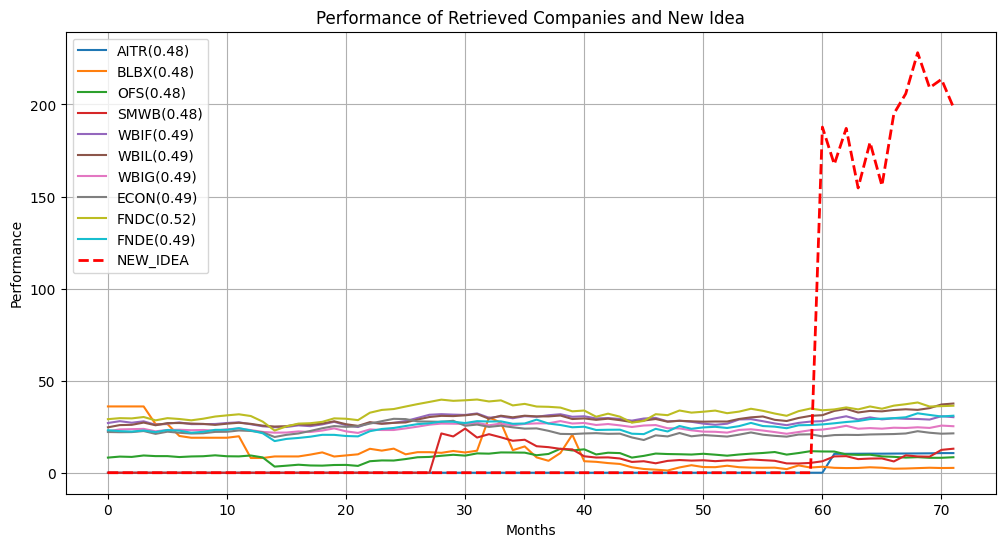

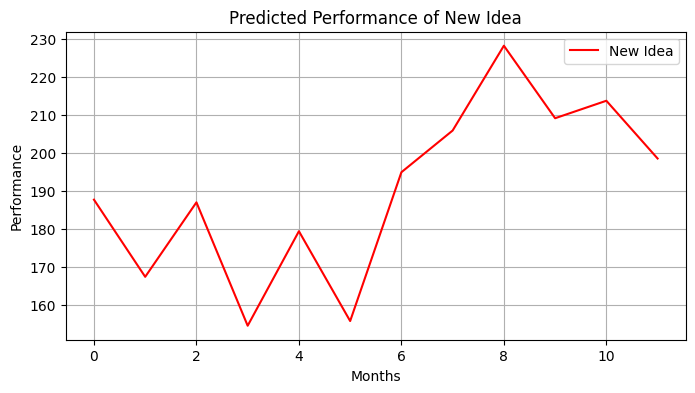


Companies Ranked by Rating:
1. SMWB - Rating: 0.5493
2. OFS - Rating: 0.3009
3. ECON - Rating: 0.2929
4. AITR - Rating: 0.2901
5. FNDE - Rating: 0.2889
6. WBIF - Rating: 0.2888
7. FNDC - Rating: 0.2760
8. BLBX - Rating: 0.2607
9. WBIG - Rating: 0.2449
10. WBIL - Rating: 0.2339
11. NEW_IDEA - Rating: 0.1880


In [60]:
if __name__ == "__main__":
    idea = "I want to build a stockprediction model that can be used to predict stock performance for potential business idea. This should help to gather first insights into the potential of an idea. Additionally it should lookup similar companies so that on overview over competitors is given. It should also rate the new idea based on the predicted stock performance and rank them among its competitors."

    # idea = "Lego Shop"

    #idea = "Able View Global Inc. operates as brand management partners of beauty and personal care brands in China. Its brand management services encompass various segments of the brand management value chain, including strategy, branding, digital and social marketing, omni-channel sales, customer services, overseas logistics, and warehouse and fulfilment. The company was incorporated in 2021 and is based in Shanghai, China."

    # idea = "An AI-driven personal finance platform that provides automated budgeting, expense tracking, and investment advice, with customizable dashboards tailored to individual financial goals."

    userinterface = UserInterface()
    response = userinterface.predict(idea)
    userinterface.visualize_results(response)

    # print(response)